In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence
from torch.autograd import Variable
from diffusers import DDPMScheduler
import os
import sys
sys.path.insert(1,"../scripts")
from get_voxels import collate_batch
from networks import EncoderCNN, UNet3D_ptcond
import torch
import torch.nn as nn
import torch.optim as optim

class Transformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        forward_expansion,
        dropout,
        max_len_s,
        max_len_t,
        device,
    ):
        super(Transformer, self).__init__()
        self.src_word_embedding = nn.Embedding(src_vocab_size, embedding_size)
        self.src_position_embedding = nn.Embedding(max_len_s, embedding_size)
        self.trg_word_embedding = nn.Embedding(trg_vocab_size, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len_t, embedding_size)

        self.device = device
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
        )
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx

    def make_src_mask(self, src):
        src_mask = src.transpose(0, 1) == self.src_pad_idx

        # (N, src_len)
        return src_mask.to(self.device)

    def forward(self, src, trg):
        src_seq_length, N = src.shape
        trg_seq_length, N = trg.shape

        src_positions = (
            torch.arange(0, src_seq_length)
            .unsqueeze(1)
            .expand(src_seq_length, N)
            .to(self.device)
        )

        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length, N)
            .to(self.device)
        )

        embed_src = self.dropout(
            (self.src_word_embedding(src) + self.src_position_embedding(src_positions))
        )
        embed_trg = self.dropout(
            (self.trg_word_embedding(trg) + self.trg_position_embedding(trg_positions))
        )

        src_padding_mask = self.make_src_mask(src)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(self.device)
        out = self.transformer(
            embed_src,
            embed_trg,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=trg_mask,
        )
        out = self.fc_out(out)
        return out, embed_src

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

smiles = []
with open("../datasets/raw/zinc15_30000000.smi") as f:
    i=0
    for i, line in enumerate(f):
        smiles.append(line[:-1])
        if i > 10000000:
            break

batch_size = 8

smiles = smiles[batch_size*1000:]

class CustomImageDataset(Dataset):
    def __init__(self, smiles):
        self.smiles = smiles

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smile = self.smiles[idx]
        return smile

smile_DS = CustomImageDataset(smiles)

# Define the networks
net = UNet3D_ptcond(5,5)

net.load_state_dict(torch.load("../models/net_pharm_weights_32000.pkl"))
net.to(device)

enc = EncoderCNN(5)
enc.load_state_dict(torch.load("../models/encoderCNN_pharm_weights_32000.pkl"))
enc.to(device)

def create_batch(src, tar , batchsize , i):
    if ((i)*batchsize + batchsize) <= len(src):
        src, tar =  src[(i)*batchsize : (i)*batchsize + batchsize].T , tar[(i)*batchsize : (i)*batchsize + batchsize].T
    else:
        src, tar =  src[(i)*batchsize:].T , tar[(i)*batchsize :].T

    return torch.tensor(src).long(),torch.tensor(tar).long()

# Model hyperparameters
src_vocab_size = 64
trg_vocab_size = 29
embedding_size = 512
num_heads = 8
num_encoder_layers = 3
num_decoder_layers = 3
dropout = 0.10
max_len_s = 512
max_len_t = 62
forward_expansion = 4
src_pad_idx = 0


# Training hyperparameters
num_epochs = 1
learning_rate = 3e-4
batch_size = 1

model = Transformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len_s,
    max_len_t,
    device,
).to(device)


# Training hyperparameters
num_epochs = 1
learning_rate = 3e-4
batch_size = 8


## Transformer training stuff
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=10, verbose=True
)

pad_idx = 0
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).cuda()



#Other training stuff
train_dataloader = DataLoader(smile_DS, batch_size=batch_size, collate_fn=collate_batch)
scheduler = DDPMScheduler(num_train_timesteps=1000)


for i, (x, captions, pharm, lengths) in enumerate(train_dataloader):

    noise = torch.randn(x.shape).to(device)
    noisy_x  = scheduler.add_noise(x.to(device), noise, torch.stack([scheduler.timesteps[999]]*x.shape[0]).to(device))
    pred = net(noisy_x, torch.stack([scheduler.timesteps[999]]*x.shape[0]).to(device), pharm.to(device))
    encoded_reps = enc(pred)
    encoded_reps = (encoded_reps - encoded_reps.min()) / (encoded_reps.max() - encoded_reps.min()) * 63
    encoded_reps = encoded_reps.int()   

    src = encoded_reps.T.to(device)
    tar = captions.T.to(device)

    optimizer.zero_grad()
    output, _ = model(src,tar)
    loss = criterion(output.view(-1, output.shape[2]), tar.reshape(-1))
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()    

    if i % 50 == 0:
        print("Batch: {}\nLoss: {}".format(i,loss.detach()))

    if i == 5000:
        break

Using device: cuda
Batch: 0
Loss: 3.475533962249756
Batch: 50
Loss: 0.002442518947646022
Batch: 100
Loss: 0.0007912630680948496
Batch: 150
Loss: 0.005664344877004623
Batch: 200
Loss: 0.00044978648656979203
Batch: 250
Loss: 0.00032481265952810645
Batch: 300
Loss: 0.019586728885769844
Batch: 350
Loss: 0.0006871015066280961
Batch: 400
Loss: 0.0002137852570740506
Batch: 450
Loss: 0.0007716587861068547
Batch: 500
Loss: 7.81981652835384e-05
Batch: 550
Loss: 0.002448386512696743
Batch: 600
Loss: 0.00010786065104184672
Batch: 650
Loss: 7.34648565412499e-05
Batch: 700
Loss: 2.9217106202850118e-05
Batch: 750
Loss: 0.0005888304440304637
Batch: 800
Loss: 0.0007276295218616724
Batch: 850
Loss: 0.006353420205414295
Batch: 900
Loss: 0.000308948423480615
Batch: 950
Loss: 0.0004408489039633423
Batch: 1000
Loss: 0.0008091475465334952
Batch: 1050
Loss: 0.00017731342813931406
Batch: 1100
Loss: 0.0004179544630460441
Batch: 1150
Loss: 0.00019898834580089897
Batch: 1200
Loss: 0.00019912120478693396
Batch: 12

RDKit ERROR: [15:03:48] UFFTYPER: Unrecognized atom type: S_5+4 (1)


Batch: 2750
Loss: 0.04484158009290695
Batch: 2800
Loss: 7.351001841016114e-05
Batch: 2850
Loss: 6.479920557467267e-05
Batch: 2900
Loss: 9.702079114504158e-05
Batch: 2950
Loss: 0.00016667568706907332
Batch: 3000
Loss: 2.1743149773101322e-05
Batch: 3050
Loss: 2.0394249077071436e-05
Batch: 3100
Loss: 1.3866791960026603e-05
Batch: 3150
Loss: 5.713662176276557e-06
Batch: 3200
Loss: 1.9146129488945007e-05
Batch: 3250
Loss: 5.028789928473998e-06
Batch: 3300
Loss: 4.613998498825822e-06
Batch: 3350
Loss: 1.5317313227569684e-05
Batch: 3400
Loss: 3.2396263122791424e-05
Batch: 3450
Loss: 6.297043000813574e-06
Batch: 3500
Loss: 1.3696310816158075e-05
Batch: 3550
Loss: 5.480726940731984e-06
Batch: 3600
Loss: 3.245378138672095e-06
Batch: 3650
Loss: 7.631164771737531e-05
Batch: 3700
Loss: 1.0596660104056355e-05
Batch: 3750
Loss: 3.550812471075915e-05
Batch: 3800
Loss: 8.549903213861398e-06
Batch: 3850
Loss: 4.852694928558776e-06
Batch: 3900
Loss: 4.815905776922591e-05
Batch: 3950
Loss: 0.0002300648484

In [13]:
input = torch.zeros(2,8)
input[0] = input[0]+1
input = input.int()


In [29]:
pred = model(src, input.to(device).int())

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [23]:
samp = torch.max(pred[0].view(-1,pred[0].shape[2]),1)[1].reshape(-1,8)

In [24]:
samp

tensor([[ 1,  1,  1,  1,  1,  1,  1,  1],
        [ 3,  5,  5, 27,  3,  3, 27,  5],
        [ 3,  1, 25,  1,  3,  3,  1, 24]], device='cuda:0')

In [21]:
input = torch.cat([samp, (torch.zeros(1,8)+1).cuda()])

In [11]:
input = torch.zeros(62,8)
input[0] = input[0]+1
input = input.int()

for i in range(58):
    pred = model(src, input.to(device).int())    
    samp = torch.max(pred[0].view(-1,pred[0].shape[2]),1)[1].reshape(-1,8)
    input = torch.cat([samp, (torch.zeros(1,8)).cuda()])

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [10]:
samp

tensor([[ 1,  1,  1,  1,  1,  1,  1,  1],
        [ 4,  4,  4,  5,  4,  4,  4,  1],
        [24, 24, 24,  6, 24, 24, 24, 24],
        [24,  4, 24,  6,  4,  4,  4, 24],
        [24, 25,  4,  6,  6, 24,  4,  6],
        [ 4, 24,  4,  6,  6, 24, 24,  6],
        [24,  4, 24,  6,  7,  8,  4,  6],
        [24, 25,  4,  6,  6, 24, 24,  8],
        [ 4, 25,  4,  6,  7,  4,  4,  6],
        [ 4, 25,  4,  6,  7, 24,  4,  6],
        [24,  4, 24,  6,  7, 24,  4,  6],
        [ 4, 25,  4,  6,  7,  3,  4,  6],
        [24,  4, 24,  3,  7, 24,  4,  6],
        [24, 25, 24,  6,  7, 24,  4,  6],
        [ 4,  5,  4,  6,  4, 24,  4,  6],
        [ 4,  4, 24,  6,  7, 24,  4,  6],
        [ 4, 11,  4,  6,  7,  3, 13,  6],
        [24,  3, 24,  6,  3,  8, 13,  6],
        [ 4, 11,  4,  6,  7, 24,  4,  6],
        [ 6,  4,  6,  6,  5, 24, 24,  6],
        [ 4, 11,  4,  6,  7, 24, 13,  6],
        [24, 24,  6,  6, 24, 24, 13,  6],
        [24,  4,  6,  6,  7, 24,  4,  6],
        [24,  4,  6,  6, 16, 24,  

In [4]:
vocab_list = ["pad", "start", "end",
    "C", "c", "N", "n", "S", "s", "P", "O", "o",
    "B", "F", "I",
    "Cl", "[nH]", "Br", # "X", "Y", "Z",
    "1", "2", "3", "4", "5", "6",
    "#", "=", "-", "(", ")"  # Misc
]

vocab_i2c_v1 = {i: x for i, x in enumerate(vocab_list)}
vocab_c2i_v1 = {vocab_i2c_v1[i]: i for i in vocab_i2c_v1}

RDKit ERROR: [15:25:08] SMILES Parse Error: extra close parentheses while parsing: c#ccc#ccC#C)#c#F#cFs#F#c#F)#[nH]##cc####Cc###F#FCc#####Fc##Fc
RDKit ERROR: [15:25:08] SMILES Parse Error: Failed parsing SMILES 'c#ccc#ccC#C)#c#F#cFs#F#c#F)#[nH]##cc####Cc###F#FCc#####Fc##Fc' for input: 'c#ccc#ccC#C)#c#F#cFs#F#c#F)#[nH]##cc####Cc###F#FCc#####Fc##Fc'
RDKit ERROR: [15:25:08] SMILES Parse Error: syntax error while parsing: #####nc#######NN#n#n#n#scnnn#nnnnnncnnnn#nnnnnnnnn#nnn#nn
RDKit ERROR: [15:25:08] SMILES Parse Error: Failed parsing SMILES '#####nc#######NN#n#n#n#scnnn#nnnnnncnnnn#nnnnnnnnn#nnn#nn' for input: '#####nc#######NN#n#n#n#scnnn#nnnnnncnnnn#nnnnnnnnn#nnn#nn'
RDKit ERROR: [15:25:08] SMILES Parse Error: syntax error while parsing: c#cn#c#cccccnccnnCnnncnnCCnnn##nn#nnnn#nnCcnnnnnnnn#nnnnnn
RDKit ERROR: [15:25:08] SMILES Parse Error: Failed parsing SMILES 'c#cn#c#cccccnccnnCnnncnnCCnnn##nn#nnnn#nnCcnnnnnnnn#nnnnnn' for input: 'c#cn#c#cccccnccnnCnnncnnCCnnn##nn#nnnn#nnCcnnnnnnnn#n

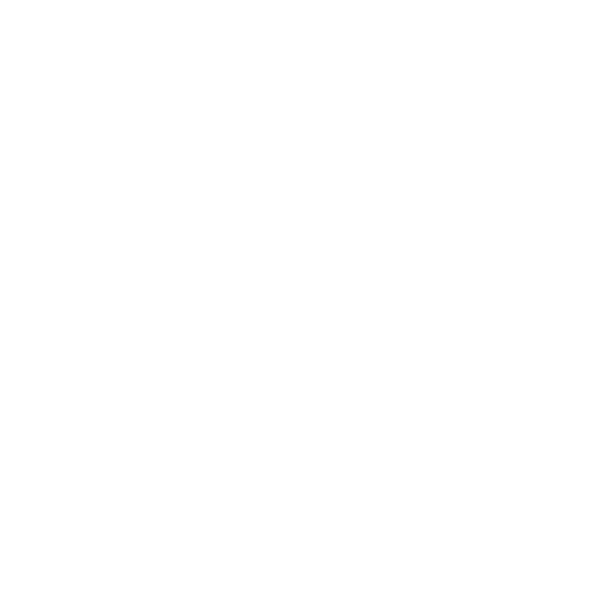

In [8]:
from rdkit.Chem import Draw
from rdkit import Chem
gen_smiles = []
for sample in samp.T:
    csmile = ""
    for xchar in sample[0:]:
        if xchar == 1:
            continue
        if xchar == 2:
            break
        csmile += [i for i in vocab_c2i_v1 if vocab_c2i_v1[i]==xchar][0]
    gen_smiles.append(csmile)
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in gen_smiles])

In [7]:
gen_smiles

['N##c#c#cc#c####c##=###=###C#CCN#Cc#=O#=ClC##',
 'NCcc######c#C#2=########=#=##N=#C=CCNNCO#===##=##',
 'C##c1#=O##C##=#c#N#N[nH]#N##cC##cN#C#N#C##=O#=#[nH]C',
 'C=#O##=##c#ONN#N##=##C##CCC###CNC=###C',
 'CCCc#[nH]##cCN3C######N=#N[nH]#=####=#CC####=#=C##',
 'N#######O##3####=#=#=########C##=#CCCONC#C####=N#[nH]#',
 'C#=c#######=####N##=###C=CCCCNNC#C##=#=##(',
 'N#c##[nH]#=##C#=C##2#3##-##N##[nH]##=####CCloCCCCO=C#Cc#C#=Cl=##']

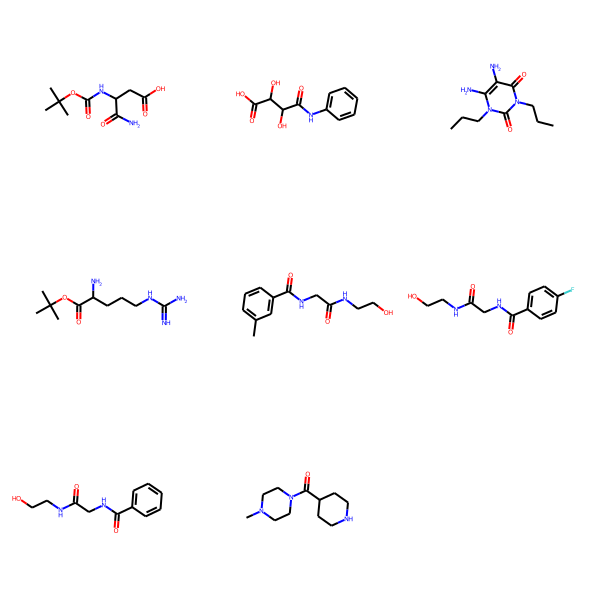

In [25]:
from rdkit.Chem import Draw
from rdkit import Chem
gen_smiles = []
for sample in samples:
    csmile = ""
    for xchar in sample[0:]:
        if xchar == 1:
            continue
        if xchar == 2:
            break
        csmile += [i for i in vocab_c2i_v1 if vocab_c2i_v1[i]==xchar][0]
    gen_smiles.append(csmile)
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in gen_smiles])

In [26]:
samples

tensor([[ 1,  3,  3, 27,  3, 28, 27,  3, 28, 10,  3, 27, 25, 10, 28,  5,  3, 27,
          3,  3, 27, 25, 10, 28, 10, 28,  3, 27,  5, 28, 25, 10,  2, 13, 28,  7,
         28, 28, 28, 11, 28, 28, 28, 28, 13, 28, 28, 13, 28, 28, 28, 28, 28, 28,
         28, 28, 27, 10, 28, 28, 28, 28],
        [ 1, 10, 25,  3, 27, 10, 28,  3, 27, 10, 28,  3, 27, 10, 28,  3, 27, 25,
         10, 28,  5,  4, 18,  4,  4,  4,  4,  4, 18,  2, 10, 28, 28, 13, 28,  8,
         28, 28, 28, 28, 28, 28, 28, 28, 28,  3,  4, 13, 28, 28, 28, 28, 28, 28,
         28, 28, 28, 28, 28, 28, 13, 28],
        [ 1,  3,  3,  3,  6, 18,  4, 27,  5, 28,  4, 27,  5, 28,  4, 27, 25, 10,
         28,  6, 27,  3,  3,  3, 28,  4, 18, 25, 10,  2, 28,  4, 28, 13, 28, 28,
         28, 28,  8, 18, 28, 28, 28, 28, 28,  3, 28, 13, 13, 28, 28, 28, 28, 28,
         28, 28, 28, 13, 28, 28,  8, 28],
        [ 1,  3,  3, 27,  3, 28, 27,  3, 28, 10,  3, 27, 25, 10, 28,  3, 27,  5,
         28,  3,  3,  3,  5,  3, 27, 25,  5, 28,  5,  2, 28, 28,

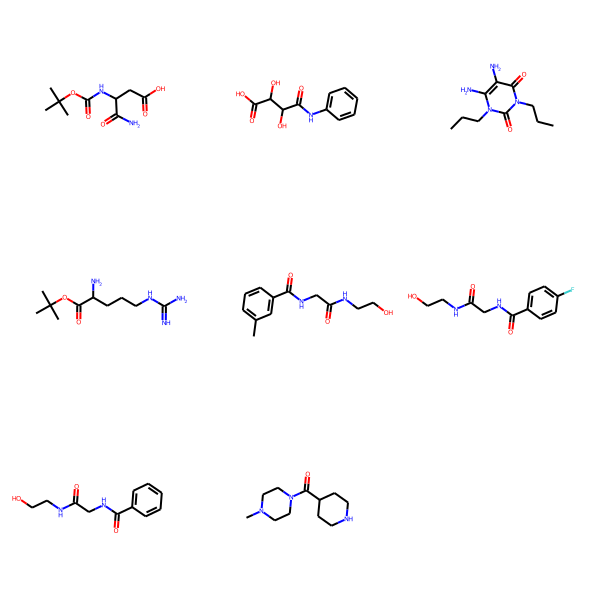

In [27]:
from rdkit.Chem import Draw
from rdkit import Chem
gen_smiles = []
for sample in tar.T:
    csmile = ""
    for xchar in sample[0:]:
        if xchar == 1:
            continue
        if xchar == 2:
            break
        csmile += [i for i in vocab_c2i_v1 if vocab_c2i_v1[i]==xchar][0]
    gen_smiles.append(csmile)
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in gen_smiles])